 # <font color="red"> MTH8408 : Méthodes d'optimisation et contrôle optimal </font>

 ## <font color="orange"> Laboratoire 3: Optimisation sans contraintes et méthodes itératives </font>


Travail réalisé par Julien Pallage

Matricule: 2012861

17 février 2024

In [1]:
using Pkg
Pkg.activate(".") #Accède au fichier Project.toml
Pkg.add("LDLFactorizations")
Pkg.add("OptimizationProblems")
Pkg.add("Plots")
Pkg.add("SolverCore")
Pkg.add("LinearOperators")
Pkg.add("BenchmarkTools")
Pkg.add("OptimizationProblems")
Pkg.add("NLPModelsJuMP")
Pkg.instantiate()
Pkg.status()

  Activating project at `~/Documents/code/MTH8408-Hiv24/lab3_JP`


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


   Resolving package versions...


  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  No Changes to `~/Documents/code/MTH8408-Hiv24/lab3_JP/Manifest.toml`


Status `~/Documents/code/MTH8408-Hiv24/lab3_JP/Project.toml`
  [54578032] ADNLPModels v0.7.0
  [ecbce9bc] BenchmarkProfiles v0.4.4
  [6e4b80f9] BenchmarkTools v1.4.0
  [7073ff75] IJulia v1.24.2
  [10dff2fc] JSOSolvers v0.11.0
  [40e66cde] LDLFactorizations v0.10.1
  [5c8ed15e] LinearOperators v2.6.0
  [a4795742] NLPModels v0.20.0
  [792afdf1] NLPModelsJuMP v0.12.5
  [5049e819] OptimizationProblems v0.7.3
  [91a5bcdd] Plots v1.40.1
  [581a75fa] SolverBenchmark v0.6.0
  [ff4d7338] SolverCore v0.3.7
  [37e2e46d] LinearAlgebra
  [de0858da] Printf


In [2]:
using BenchmarkTools, SolverCore, LinearOperators
using JSOSolvers, NLPModels, OptimizationProblems # 
using ADNLPModels
using SolverBenchmark
using LinearAlgebra, NLPModels, Printf
using OptimizationProblems.ADNLPProblems

###  <font color="lightgreen"> Exercice 1: Méthode quasi-Newton L-BFGS </font>

Compléter votre implémentation de la méthode L-BFGS et illustrer son utilisation sur un des problèmes sans contraintes de la collection OptimizationProblems.jl.

---
---

SOLUTION:

In [22]:
"""
Function that implements an armijo line search
Obligatory inputs: xk, dk, fk, gk, slope, nlp.
Outputs: armijo parameter t, new fk.
"""
function armijo(xk, dk, fk, gk, slope, nlp :: AbstractNLPModel; τ1 = 1.0e-4, t_update = 1.5)
    t = 1.0
    fk_new = obj(nlp, xk + dk) # t = 1.0
    while fk_new > fk + τ1 * t * slope
      t /= t_update
      fk_new = obj(nlp, xk + t * dk)
    end
    return t, fk_new
end

"""
Function that solves an unconstrained nlp object with a limited bfgs algorithm
Obligatory inputs: nlp object,
Outputs: Execution Stats
"""
function limited_bfgs(nlp      :: AbstractNLPModel;
    x        :: AbstractVector = nlp.meta.x0,
    atol     :: Real = √eps(eltype(x)), 
    rtol     :: Real = √eps(eltype(x)),
    max_eval :: Int = -1,
    max_time :: Float64 = 30.0,
    f_min    :: Float64 = -1.0e16,
    verbose  :: Bool = true,
    mem      :: Int = 5)
  start_time = time()
  elapsed_time = 0.0

  T = eltype(x)
  n = Int(nlp.meta.nvar)

  xt = zeros(T, n)
  ∇ft = zeros(T, n)

  f = obj(nlp, x)
  ∇f = grad(nlp, x)
  #################################################
  H = InverseLBFGSOperator(n;mem=mem) ### Use InverseLBFGSOperator instead of I ###
  #################################################

  ∇fNorm = norm(∇f) #nrm2(n, ∇f)
  ϵ = atol + rtol * ∇fNorm
  iter = 0

  @info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
  hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

  optimal = ∇fNorm ≤ ϵ
  unbdd = f ≤ f_min
  tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  stalled = false
  status = :unknown

  while !(optimal || tired || stalled || unbdd)

    #################################################
    d = H*∇f ### Compute d
    d *= -1 ### Somehow fixes a bug to proceed like this
    #################################################
    slope = dot(d, ∇f)
    if slope ≥ 0
      @error "not a descent direction" slope
      status = :not_desc
      stalled = true
    continue
    end

    # Perform improved Armijo linesearch.
    t, ft = armijo(x, d, f, ∇f, slope, nlp)

    @info log_row(Any[iter, f, ∇fNorm, slope, t])

    # Update L-BFGS approximation.
    xt = x + t * d
    ∇ft = grad(nlp, xt) # grad!(nlp, xt, ∇ft)
    #################################################
    st = xt - x
    yt = ∇ft -  ∇f
    push!(H, st, yt) ### Update H with a new st and yt
    #################################################

    # Move on.
    x = xt
    f = ft
    ∇f = ∇ft

    ∇fNorm = norm(∇f) #nrm2(n, ∇f)
    iter = iter + 1

    optimal = ∇fNorm ≤ ϵ
    unbdd = f ≤ f_min
    elapsed_time = time() - start_time
    tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  end
  @info log_row(Any[iter, f, ∇fNorm])

  if optimal
    status = :first_order
  elseif tired
  if neval_obj(nlp) > max_eval ≥ 0
    status = :max_eval
  elseif elapsed_time > max_time
    status = :max_time
  end
  elseif unbdd
    status = :unbounded
  end

  return GenericExecutionStats(
  nlp,
  status=status,
  solution=x,
  objective=f,
  dual_feas=∇fNorm,
  iter=iter,
  elapsed_time=elapsed_time,
  )
end

limited_bfgs

Nous illustrons son utilisation et sa performance sur le problème unconstrained Tridia de la collection OptimizationProblems.jl. Nous travaillerons avec 100 variables.

In [23]:
OptimizationProblems.tridia_meta

Dict{Symbol, Any} with 17 entries:
  :has_equalities_only    => false
  :origin                 => :unknown
  :has_inequalities_only  => false
  :defined_everywhere     => missing
  :has_fixed_variables    => false
  :variable_ncon          => false
  :nvar                   => 100
  :is_feasible            => true
  :minimize               => true
  :ncon                   => 0
  :name                   => "tridia"
  :best_known_lower_bound => -Inf
  :objtype                => :other
  :best_known_upper_bound => 5049.0
  :has_bounds             => false
  :variable_nvar          => true
  :contype                => :unconstrained

In [24]:
n = 100
nlp = tridia(n=n)

stats = limited_bfgs(nlp)


┌ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:49
┌ Info:      0   5.0e+03   1.2e+03  -1.4e+06   7.7e-03
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      1   2.0e+03   1.6e+03  -4.8e+03   6.7e-01
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      2   1.1e+03   1.2e+03  -1.3e+03   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      3   4.5e+02   3.1e+02  -1.1e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      4   3.5e+02   2.3e+02  -3.2e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      5   1.7e+02   2.2e+02  -1.7e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:      6   1.5e+02   4.3e+02  -1.0e+02  

┌ Info:     73   1.5e-03   6.5e-01  -8.7e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     74   1.4e-03   8.3e-01  -4.7e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     75   1.1e-03   2.8e-01  -1.2e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     76   9.7e-04   2.4e-01  -2.5e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     77   7.9e-04   3.2e-01  -3.3e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     78   5.9e-04   5.2e-01  -4.0e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     79   4.4e-04   3.9e-01  -1.4e-04   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:     80   3.3e-04   2.0e-01  -1.2e-04   1

┌ Info:    147   8.8e-09   4.2e-04  -5.1e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    148   8.5e-09   3.4e-04  -2.8e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    149   8.2e-09   3.6e-04  -8.1e-10   6.7e-01
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    150   8.1e-09   8.3e-04  -4.8e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    151   7.8e-09   3.1e-04  -1.6e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    152   7.7e-09   2.8e-04  -3.5e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    153   7.4e-09   3.9e-04  -5.2e-10   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:75
┌ Info:    154   7.0e-09   5.3e-04  -1.3e-09   1

"Execution stats: first-order stationary"

In [25]:
print(stats)

Generic Execution stats
  status: first-order stationary
  objective value: 1.2824360088337822e-11
  primal feasibility: 0.0
  dual feasibility: 1.533229397405431e-5
  solution: [0.9999965771090676  0.4999983282656731  0.24999917035173627  0.12499953412164919 ⋯ 4.3035947366902296e-10]
  iterations: 188
  elapsed time: 0.01155400276184082


As we see, it took 188 iterations to converge to a local mimimum of approximately 0.

###  <font color="lightgreen"> Exercice 2: Méthode Newton-CG </font>

Compléter votre implémentation de la méthode Newton-CG et illustrer son utilisation sur un des problèmes sans contraintes de la collection OptimizationProblems.jl.

---
---

SOLUTION:

In [27]:
"""
Function that obtains a search direction with the conjugate gradient algorithm
Inputs: Hessian and gradient
Ouput: A new direction 
"""
function cg_optim(H, ∇f)
    #setup the tolerance:
    n∇f = norm(∇f)
#####################################
    ϵk = min(0.5, sqrt(n∇f)).*n∇f # added
####################################
    n = length(∇f)
    z = zeros(n)
    r = ∇f
    d = -r
    
    j = 0
    while norm(r) ≥ ϵk && j < 3 * n
###############################################
        if dot(d, H * d) ≤ 0
            pk = (j == 0) ? - ∇f : z # added
        end
##############################################
        α =dot(r,r)./(dot(d, H * d)) # added
##############################################        
        z += α * d
        nrr2 = dot(r, r)
        r += α * H * d
##############################################
        β  = dot(r,r)./nrr2 # added
##############################################
        d  = -r + β.*d
        j += 1
    end
    return z # or return d?
end



"""
Function that uses an armijo linesearch, with a Newton algorithm while using a conjugate gradient direction each step 
Inputs: An NLP object and other mandatory parameters.
Ouptut: Execution stats.

"""
function armijo_Newton_cg(nlp      :: AbstractNLPModel;
                          x        :: AbstractVector = nlp.meta.x0,
                          atol     :: Real = √eps(eltype(x)), 
                          rtol     :: Real = √eps(eltype(x)),
                          max_eval :: Int = -1,
                          max_time :: Float64 = 30.0,
                          f_min    :: Float64 = -1.0e16)
  start_time = time()
  elapsed_time = 0.0

  T = eltype(x)
  n = nlp.meta.nvar

  f = obj(nlp, x)
  ∇f = grad(nlp, x)
#################################################
  H = hess_op(nlp, x)  ### Initialize H as linear operator representing the Hessian matrix 
#################################################

  ∇fNorm = norm(∇f) #nrm2(n, ∇f)
  ϵ = atol + rtol * ∇fNorm
  iter = 0

  @info log_header([:iter, :f, :dual, :slope, :bk], [Int, T, T, T, T],
                   hdr_override=Dict(:f=>"f(x)", :dual=>"‖∇f‖", :slope=>"∇fᵀd"))

  optimal = ∇fNorm ≤ ϵ
  unbdd = f ≤ f_min
  tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  stalled = false
  status = :unknown

  while !(optimal || tired || stalled || unbdd)
        
    d = cg_optim(H, ∇f) 
        
    slope = dot(d, ∇f)
    if slope ≥ 0
      @error "not a descent direction" slope
      status = :not_desc
      stalled = true
      continue
    end

    # Perform improved Armijo linesearch.
    t, f = armijo(x, d, f, ∇f, slope, nlp)
        
    @info log_row(Any[iter, f, ∇fNorm, slope, t])

    # Update L-BFGS approximation.
    x += t * d
    ∇f = grad(nlp, x)
#################################################
    H = hess_op(nlp, x) ### Update H!
#################################################

    ∇fNorm = norm(∇f) #nrm2(n, ∇f)
    iter = iter + 1

    optimal = ∇fNorm ≤ ϵ
    unbdd = f ≤ f_min
    elapsed_time = time() - start_time
    tired = neval_obj(nlp) > max_eval ≥ 0 || elapsed_time > max_time
  end
  @info log_row(Any[iter, f, ∇fNorm])

  if optimal
    status = :first_order
  elseif tired
    if neval_obj(nlp) > max_eval ≥ 0
      status = :max_eval
    elseif elapsed_time > max_time
      status = :max_time
    end
  elseif unbdd
        status = :unbounded
  end

  return GenericExecutionStats(nlp, status = status, solution=x, objective=f, dual_feas=∇fNorm,
                               iter=iter, elapsed_time=elapsed_time)
end

armijo_Newton_cg

Une deuxième fois, illustrons sa performance sur le problème `tridia` avec 100 variables.

In [28]:
n = 100
nlp = tridia(n=n)
stats = armijo_Newton_cg(nlp)

┌ Info:   iter      f(x)      ‖∇f‖      ∇fᵀd        bk  
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:69
┌ Info:      0   6.3e+02   1.2e+03  -8.8e+03   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      1   1.2e+02   5.1e+02  -1.0e+03   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      2   2.7e+01   2.0e+02  -1.8e+02   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      3   1.5e+01   9.7e+01  -2.3e+01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      4   2.2e+00   4.4e+01  -2.5e+01   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      5   4.9e-01   1.7e+01  -3.5e+00   1.0e+00
└ @ Main /home/julien/Documents/code/MTH8408-Hiv24/lab3_JP/lab3_pallage.ipynb:93
┌ Info:      6   2.4e-01   7.7e+00  -5.1e-01  

"Execution stats: first-order stationary"

In [29]:
print(stats)

Generic Execution stats
  status: first-order stationary
  objective value: 3.37580889992935e-13
  primal feasibility: 0.0
  dual feasibility: 1.1199496148809964e-5
  solution: [0.9999999912018402  0.5000000300459599  0.2500000476635215  0.12499997802900703 ⋯ 2.570225077445835e-9]
  iterations: 15
  elapsed time: 0.026151180267333984


Ici, on remarque que ça a pris seulement 15 itérations pour converger à un minimum local de valeur similaire l'exercice 1 et ce deux fois plus rapidement!

###  <font color="lightgreen"> Exercice 3: Benchmark LBFGS vs Taille mémoire </font>

Comparer LBFGS avec mémoire m = 1, m = 5 et m = 20 sur une collection de problèmes sans contraintes de OptimizationProblems.jl.
Préciser combien de problèmes sont utilisés, inclure des profils de performance, et mentionner un/des problèmes qui ne sont pas résolus par l’algorithme.

---
---

SOLUTION:

In [10]:
OptimizationProblems.meta

Row,nvar,variable_nvar,ncon,variable_ncon,minimize,name,has_equalities_only,has_inequalities_only,has_bounds,has_fixed_variables,objtype,contype,best_known_lower_bound,best_known_upper_bound,is_feasible,defined_everywhere,origin
,Int64,Bool,Int64,Bool,Bool,String,Bool,Bool,Bool,Bool,Symbol,Symbol,Real,Real,Bool?,Bool?,Symbol
1,1,false,0,false,true,AMPGO02,false,false,false,false,other,unconstrained,-Inf,0.839498,true,missing,unknown
2,1,false,0,false,true,AMPGO03,false,false,false,false,other,unconstrained,-Inf,2.88961,true,missing,unknown
3,1,false,0,false,true,AMPGO04,false,false,false,false,other,unconstrained,-Inf,-2.5666,true,missing,unknown
4,1,false,0,false,true,AMPGO05,false,false,false,false,other,unconstrained,-Inf,-0.0,true,missing,unknown
5,1,false,0,false,true,AMPGO06,false,false,false,false,other,unconstrained,-Inf,3.5177e-43,true,missing,unknown
6,1,false,0,false,true,AMPGO07,false,false,false,false,other,unconstrained,-Inf,2.56475,true,missing,unknown
7,1,false,0,false,true,AMPGO08,false,false,false,false,other,unconstrained,-Inf,-2.0928,true,missing,unknown
8,1,false,0,false,true,AMPGO09,false,false,false,false,other,unconstrained,-Inf,0.921136,true,missing,unknown
9,1,false,0,false,true,AMPGO10,false,false,false,false,other,unconstrained,-Inf,-0.0,true,missing,unknown


Ici, on utilise la documentation de la librairie OptimizationProblems https://jso.dev/OptimizationProblems.jl/dev/benchmark/ pour obtenir les problèmes à résoudre et déclarer les solveurs dans un dictionnaire.

On initialise la mémoire à 5,10,20 avec limited_bfgs afin de voir l'impact de la mémoire sur la performance.

In [30]:

ad_problems = (eval(Meta.parse(problem))()  for problem ∈ OptimizationProblems.meta[!, :name])


solvers = Dict(
  :lbfgs_5 => model -> limited_bfgs(model; mem=5),
  :lbfgs_10 => model -> limited_bfgs(model; mem=10),
  :lbfgs_20 => model -> limited_bfgs(model; mem=20),
)

stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 150 || get_nvar(prob) < 5),
)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:            NZF1      91       0      first_order   3.0e-01   2.1e+04   3.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         arglina     100       0      first_order   2.8e-01   5.0e+01   7.8e-15   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinb     100       0      first_order   2.1e-01   2.5e+01   3.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         arglinc     100       0      first_order   2.1e-01   5.1e+01   4.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         argtrig     100       0      first_order   2.2e-01  -9.9e+03   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         arwhead     100       0      first_order   1.8e-01   0.0e+00   5.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         bdqrtic     100       0      first_order   2.3e-01   1.9e+02   2.1e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          biggs6       6       0        unbounded   2.2e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         brownal     100       0      first_order   2.3e-01   1.9e-09   6.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:       broyden3d     100       0      first_order   2.1e-01   3.6e-01   1.4e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        broydn7d     100       0      first_order   3.0e-01   3.6e+01   7.6e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          brybnd     100       0      first_order   3.0e-01   1.3e+00   1.4e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Info:        chainwoo     100       0      first_order   2.3e-01   1.0e+00   7.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        chnrosnb     100       0      first_order   2.3e-01   2.3e-10   7.4e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        clplatea     100       0      first_order   4.5e-01  -9.1e-03   1.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        clplateb     100       0      first_order   4.8e-01  -6.2e-03   1.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        clplatec     100       0      first_order   5.2e-01  -5.1e-03   1.6e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          cosine     100       0      first_order   1.9e-01  -9.9e+01   5.2e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        cragglvy     100       0      first_order   2.4e-01   3.2e+01   5.7e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:       cragglvy2     100       0      first_order   2.1e-01   2.5e+01   5.0e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           curly     100       0         max_time   3.0e+01  -1.0e+04   3.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly10     100       0         max_time   3.0e+01  -1.0e+04   3.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         curly20     100       0         max_time   3.0e+01  -1.0e+04   9.4e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly30     100       0         max_time   3.0e+01  -1.0e+04   7.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12


┌ Info:        dixmaane      99       0      first_order   3.1e-01   1.0e+00   2.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12


┌ Info:        dixmaanf      99       0      first_order   2.6e-01   1.0e+00   4.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaang      99       0      first_order   4.4e-03   1.0e+00   8.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaanh      99       0      first_order   4.2e-03   1.0e+00   2.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaani      99       0      first_order   3.4e-01   1.0e+00   2.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_ijkl.jl:12


┌ Info:        dixmaanj      99       0      first_order   3.1e-01   1.0e+00   4.9e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_ijkl.jl:12
┌ Info:        dixmaank      99       0      first_order   1.6e-02   1.0e+00   9.3e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_ijkl.jl:12
┌ Info:        dixmaanl      99       0      first_order   1.3e-02   1.0e+00   1.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaanm      99       0      first_order   3.3e-01   1.0e+00   1.2e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12


┌ Info:        dixmaann      99       0      first_order   3.4e-01   1.0e+00   2.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaano      99       0      first_order   3.3e-02   1.0e+00   4.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanp      99       0      first_order   4.3e-02   1.0e+00   9.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        dixon3dq 

┌ Info:         dqdrtic     100       0      first_order   1.8e-01   3.8e-11   7.3e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          dqrtic     100       0      first_order   2.1e-01   6.1e-02   1.6e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         edensch     100       0      first_order   1.9e-01   6.0e+02   3.5e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:             eg2     100       0      first_order   1.8e-01  -9.7e+01   8.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         engval1     100       0      first_order   2.1e-01   1.1e+02   1.4e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:            enso       9       0      first_order   1.3e-03   3.9e+02   4.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        errinros     100       0      first_order   2.2e-01   3.9e+01   1.2e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        extrosnb     100       0      first_order   1.8e-01   1.2e-11   1.5e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        fletcbv2     100       0      first_order   2.6e-01  -5.1e-01   1.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        fletcbv3     100       0      first_order   2.3e-01  -2.0e+00   2.1e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        fletchcr     100       0      first_order   2.2e-01   3.4e-13   4.0e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        fminsrf2     100       0      first_order   2.7e-01   1.0e+02   4.6e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        freuroth     100       0      first_order   2.6e-01   6.0e+03   2.2e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss1       8       0         max_time   3.0e+01   6.6e+02   6.5e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          gauss2       8       0      first_order   7.4e-02   6.2e+02   6.2e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0         max_time   3.0e+01   6.2e+02   5.8e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        genhumps     100       0      first_order   2.7e-01   6.6e-13   5.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         genrose     100       0      first_order   2.0e-01   1.0e+00   7.5e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:    genrose_nash     100       0      first_order   2.4e-01   1.0e+00   6.3e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           indef     100       0         max_time   3.0e+01  -9.8e+03   8.4e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        integreq     100       0      first_order   4.4e-01   5.9e-17   1.1e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          kirby2       5       0      first_order   2.6e-03   1.5e+01   5.4e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.8e-04   2.1e-06   4.4e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   3.0e-04   2.1e-06   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first_order   3.1e-04   2.2e-06   4.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         liarwhd     100       0      first_order   1.9e-01   8.8e-12   1.0e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0      first_order   5.6e-05   5.5e-02   8.7e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          morebv     100       0      first_order   1.3e+00   2.4e-12   3.7e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           ncb20     100       0         max_time   3.0e+01   1.6e+02   1.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          ncb20b     100       0         max_time   3.0e+01   2.0e+02   3.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxu2     100       0      first_order   2.4e-01   2.3e+02   1.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        noncvxun     100       0      first_order   2.1e-01   2.3e+02   1.2e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          nondia     100       0      first_order   1.9e-01   1.4e-12   5.8e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        nondquar     100       0      first_order   2.8e-01   1.3e-06   5.9e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne1       5       0         max_time   3.0e+01   2.3e-02   3.1e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        osborne2      11       0      first_order   2.9e-03   2.0e-02   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   3.6e-01   8.4e+01   3.5e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer1d       7       0      first_order   3.1e-01   1.4e+01   3.0e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   9.5e-02   2.2e+00   2.2e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer3c       8       0      first_order   7.1e-02   1.7e+00   8.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer4c       8       0      first_order   6.3e-02   2.4e+00   8.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer5c       6       0      first_order   4.5e-04   1.1e+00   3.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer6c       8       0      first_order   2.8e-01   4.8e-02   7.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        palmer7c       8       0      first_order   2.8e-01   2.2e+00   2.8e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer8c       8       0      first_order   1.7e-01   3.0e-01   8.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        penalty1     100       0      first_order   2.5e-01   1.2e+00   4.0e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        penalty2     100       0      first_order   2.7e-01   9.7e+04   1.6e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        penalty3     100       0      first_order   3.8e-01   1.0e+00   3.6e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        powellsg     100       0      first_order   2.1e-01   6.1e-10   2.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           power     100       0      first_order   2.3e-01   2.7e-03   7.2e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          quartc     100       0      first_order   1.9e-01   6.1e-02   1.6e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         sbrybnd     100       0      first_order   1.7e+00   1.4e+01   4.0e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        schmvett     100       0      first_order   2.0e-01  -2.9e+02   1.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         scosine     100       0         max_time   3.0e+01  -7.4e+01   1.6e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         sinquad     100       0      first_order   2.1e-01   1.8e-15   4.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        sparsine     100       0      first_order   2.6e-01   3.5e-10   1.2e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsqur     100       0      first_order   2.1e-01   2.9e-08   9.5e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        spmsrtls     100       0      first_order   4.8e-01   4.2e-15   6.1e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        srosenbr     100       0      first_order   2.0e-01   8.2e-15   2.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         thurber       7       0      first_order   9.9e-02   2.8e+03   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        tointgss     100       0      first_order   2.0e-01   9.7e+00   2.5e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        tquartic     100       0      first_order   1.9e-01   1.7e-20   8.2e-10   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          tridia     100       0      first_order   2.0e-03   1.3e-11   1.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          vardim     100       0      first_order   2.7e-01   2.5e+03   8.2e+05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        vibrbeam       8       0      first_order   4.4e-03   4.6e+00   5.3e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          watson      31       0        unbounded   3.2e-03  -3.8e+90   8.1e+90   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           woods     100       0      first_order   2.1e-01   2.6e-09   3.9e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:            NZF1      91       0      first_order   1.1e-03   2.1e+04   2.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglina     100       0      first_order   1.3e-04   5.0e+01   7.8e-15   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinb     100       0      first_order   1.4e-04   2.5e+01   3.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinc     100       0      first_order   1.0e-04   5.1e+01   4.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         argtrig     100       0      fir

┌ Info:         arwhead     100       0      first_order   1.6e-04   0.0e+00   2.9e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         bdqrtic     100       0      first_order   5.9e-04   1.9e+02   1.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          biggs6       6       0        unbounded   1.8e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         brownal     100       0      first_order   9.4e-05   1.9e-09   6.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:       broyden3d     100       0      first_order   1.3e-03   3.6e-01   3.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        broydn7d     100       0      first

┌ Info:          cosine     100       0      first_order   3.6e-04  -9.9e+01   2.8e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        cragglvy     100       0      first_order   1.7e-03   3.2e+01   3.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:       cragglvy2     100       0      first_order   1.7e-03   2.5e+01   5.6e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           curly     100       0         max_time   3.0e+01  -1.0e+04   3.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly10     100       0         max_time   3.0e+01  -1.0e+04   3.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         curly20     100       0         max_time   3.0e+01  -1.0e+04   5.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly30     100       0         max_time   3.0e+01  -1.0e+04   3.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaane      99       0      first_order   3.9e-03   1.0e+00   1.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaanf      99       0      first_order   4.2e-03   1.0e+00   3.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaanl      99       0      first_order   1.4e-02   1.0e+00   1.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanm      99       0      first_order   5.0e-02   1.0e+00   1.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaann      99       0      first_order   3.2e-02   1.0e+00   2.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaano      99       0      first_order   3.2e-02   1.0e+00   4.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanp      99       0      first_order   3.4e-02   1.0e+00   8.0e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        dixon3dq     100       0      first_order   4.0e-03   3.4e-14   4.8e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         dqdrtic     100       0      first_order   2.0e-04   4.0e-12   4.3e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          dqrtic     100      

┌ Info:        genhumps     100       0      first_order   6.5e-02   3.5e-11   3.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         genrose     100       0      first_order   4.0e-03   1.0e+00   1.8e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:    genrose_nash     100       0      first_order   1.9e-02   1.0e+00   1.2e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           indef     100       0         max_time   3.0e+01  -9.8e+03   6.6e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        integreq     100       0      first_order   2.0e-02   5.8e-17   1.1e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.5e-03   1.5e+01   5.5e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.0e-04   2.1e-06   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   2.2e-04   2.1e-06   3.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first

┌ Info:          morebv     100       0      first_order   4.7e-01   2.7e-11   3.7e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           ncb20     100       0         max_time   3.0e+01   1.7e+02   6.6e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          ncb20b     100       0         max_time   3.0e+01   2.0e+02   2.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxu2     100       0      first_order   1.3e-02   2.3e+02   1.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxun     100       0      first_order   4.7e-03   2.3e+02   1.5e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          nondia     100       0      first_order   3.8e-04   3.4e-15   7.8e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        nondquar     100       0      first_order   2.5e-02   7.4e-07   5.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne1       5       0         ma

┌ Info:        osborne2      11       0      first_order   7.3e-04   2.0e-02   2.6e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   6.1e-03   8.4e+01   1.8e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   6.0e-03   1.4e+01   2.5e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   3.8e-03   2.2e+00   9.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first_order   2.1e-03   1.7e+00   7.8e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer4c       8       0      first

┌ Info:         sbrybnd     100       0      first_order   3.2e+00   7.6e+00   3.7e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        schmvett     100       0      first_order   6.5e-04  -2.9e+02   1.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         scosine     100       0         max_time   3.0e+01  -7.8e+01   2.8e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         sinquad     100       0      first_order   2.8e-03   9.8e-16   3.9e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsine     100       0      first_order   1.9e-02   4.3e-10   9.1e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsqur     100       0      first_order   6.4e-04   4.7e-08   1.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        spmsrtls     100       0      first_order   8.0e-03   7.7e-15   7.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        srosenbr     100       0      first

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:            NZF1      91       0      first_order   1.6e-03   2.1e+04   3.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglina     100       0      first_order   1.3e-04   5.0e+01   7.8e-15   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinb     100       0      first_order   1.2e-04   2.5e+01   3.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinc     100       0      first_order   9.0e-05   5.1e+01   4.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         argtrig     100       0      fir

┌ Info:          cosine     100       0      first_order   4.1e-04  -9.9e+01   2.9e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        cragglvy     100       0      first_order   1.7e-03   3.2e+01   5.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:       cragglvy2     100       0      first_order   2.2e-03   2.5e+01   3.6e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           curly     100       0      first_order   1.9e-01  -1.0e+04   2.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly10     100       0      first_order   2.0e-01  -1.0e+04   2.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         curly20     100       0         max_time   3.0e+01  -1.0e+04   5.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly30     100       0         max_time   3.0e+01  -1.0e+04   1.2e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaane      99       0      first_order   4.6e-03   1.0e+00   2.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaanf      99       0      first_order   4.2e-03   1.0e+00   3.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaanl      99       0      first_order   1.4e-02   1.0e+00   2.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanm      99       0      first_order   5.4e-02   1.0e+00   1.2e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaann      99       0      first_order   4.2e-02   1.0e+00   2.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaano      99       0      first_order   4.1e-02   1.0e+00   4.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanp      99       0      first_order   2.9e-02   1.0e+00   1.1e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        dixon3dq     100       0      first_order   4.7e-03   2.2e-14   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         dqdrtic     100       0      first_order   1.9e-04   4.0e-12   4.3e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          dqrtic     100      

┌ Info:          gauss2       8       0         max_time   3.0e+01   6.2e+02   2.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0         max_time   3.0e+01   6.2e+02   7.8e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        genhumps     100       0      first_order   5.6e-02   4.0e-10   1.1e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         genrose     100       0      first_order   3.2e-03   1.0e+00   1.9e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:    genrose_nash     100       0      first_order   3.7e-03   1.0e+00   1.5e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           indef     100       0      first_order   3.4e-03  -9.8e+03   5.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        integreq     100       0      first_order   2.0e-02   5.8e-17   1.1e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.5e-03   1.5e+01   6.1e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.0e-04   2.1e-06   8.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   2.2e-04   2.1e-06   3.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first

┌ Info:          morebv     100       0      first_order   5.6e-01   1.8e-12   3.4e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           ncb20     100       0         max_time   3.0e+01   1.6e+02   8.3e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          ncb20b     100       0         max_time   3.0e+01   2.0e+02   4.2e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxu2     100       0      first_order   1.0e-02   2.3e+02   1.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxun     100       0      first_order   6.6e-03   2.3e+02   8.9e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          nondia     100       0      first_order   3.5e-04   1.0e-13   1.1e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        nondquar     100       0      first_order   3.2e-02   7.9e-07   5.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne1       5       0         ma

┌ Info:        osborne2      11       0      first_order   1.2e-03   2.0e-02   5.5e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   1.2e-02   8.4e+01   1.4e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   1.9e-02   1.4e+01   2.1e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   1.1e-02   2.2e+00   8.6e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first_order   2.2e-02   1.7e+00   8.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer4c       8       0      first

┌ Info:        palmer7c       8       0      first_order   4.2e-03   2.7e+00   2.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer8c       8       0      first_order   4.7e-03   3.0e-01   1.3e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        penalty1     100       0      first_order   4.7e-04   1.2e+00   4.0e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        penalty2     100       0      first_order   2.9e-03   9.7e+04   2.2e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        penalty3     100       0      first_order   3.1e-03   1.0e+00   5.2e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        powellsg     100       0      first

┌ Info:         sbrybnd     100       0      first_order   1.1e+00   1.4e+01   3.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        schmvett     100       0      first_order   6.4e-04  -2.9e+02   2.2e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         scosine     100       0         max_time   3.0e+01  -7.5e+01   2.2e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         sinquad     100       0      first_order   3.5e-03   6.1e-16   5.7e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsine     100       0      first_order   2.4e-02   4.5e-10   1.1e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsqur     100       0      first_order   5.2e-04   5.1e-08   1.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        spmsrtls     100       0      first_order   8.1e-03   8.1e-15   8.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        srosenbr     100       0      first

Dict{Symbol, DataFrames.DataFrame} with 3 entries:
  :lbfgs_5  => 105×39 DataFrame…
  :lbfgs_20 => 105×39 DataFrame…
  :lbfgs_10 => 105×39 DataFrame…

In [31]:
# this code was found as is @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)
for solver ∈ keys(solvers)
    pretty_stats(stats[solver][!, cols], hdr_override=header)
  end

┌────────┬──────────────┬────────┬───────────┬───────────┬──────────┬─────────┬────────┬─────────┬───────────┬─────────────┐
│     id │         name │      n │      f(x) │   ‖∇f(x)‖ │      # f │    # ∇f │  # ∇²f │    iter │         t │      status │
├────────┼──────────────┼────────┼───────────┼───────────┼──────────┼─────────┼────────┼─────────┼───────────┼─────────────┤
│     25 │         NZF1 │     91 │  2.09e+04 │  3.66e-05 │      229 │     194 │      0 │     193 │  3.03e-01 │ first_order │
│     38 │      arglina │    100 │  5.00e+01 │  7.84e-15 │        2 │       2 │      0 │       1 │  2.78e-01 │ first_order │
│     39 │      arglinb │    100 │  2.48e+01 │  3.28e-04 │       70 │       3 │      0 │       2 │  2.13e-01 │ first_order │
│     40 │      arglinc │    100 │  5.11e+01 │  4.44e-03 │       71 │       3 │      0 │       2 │  2.14e-01 │ first_order │
│     41 │      argtrig │    100 │ -9.90e+03 │  5.47e-08 │      136 │     108 │      0 │     107 │  2.22e-01 │ first_order │


┌────────┬──────────────┬────────┬───────────┬───────────┬──────────┬────────┬────────┬────────┬───────────┬─────────────┐
│     id │         name │      n │      f(x) │   ‖∇f(x)‖ │      # f │   # ∇f │  # ∇²f │   iter │         t │      status │
├────────┼──────────────┼────────┼───────────┼───────────┼──────────┼────────┼────────┼────────┼───────────┼─────────────┤
│     25 │         NZF1 │     91 │  2.09e+04 │  2.96e-05 │      295 │    156 │      0 │    155 │  1.62e-03 │ first_order │
│     38 │      arglina │    100 │  5.00e+01 │  7.84e-15 │        2 │      2 │      0 │      1 │  1.26e-04 │ first_order │
│     39 │      arglinb │    100 │  2.48e+01 │  3.28e-04 │       70 │      3 │      0 │      2 │  1.23e-04 │ first_order │
│     40 │      arglinc │    100 │  5.11e+01 │  4.44e-03 │       71 │      3 │      0 │      2 │  8.99e-05 │ first_order │
│     41 │      argtrig │    100 │ -9.90e+03 │  1.01e-07 │     1354 │    228 │      0 │    227 │  8.77e-03 │ first_order │
│     42 │      

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16
┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16
┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


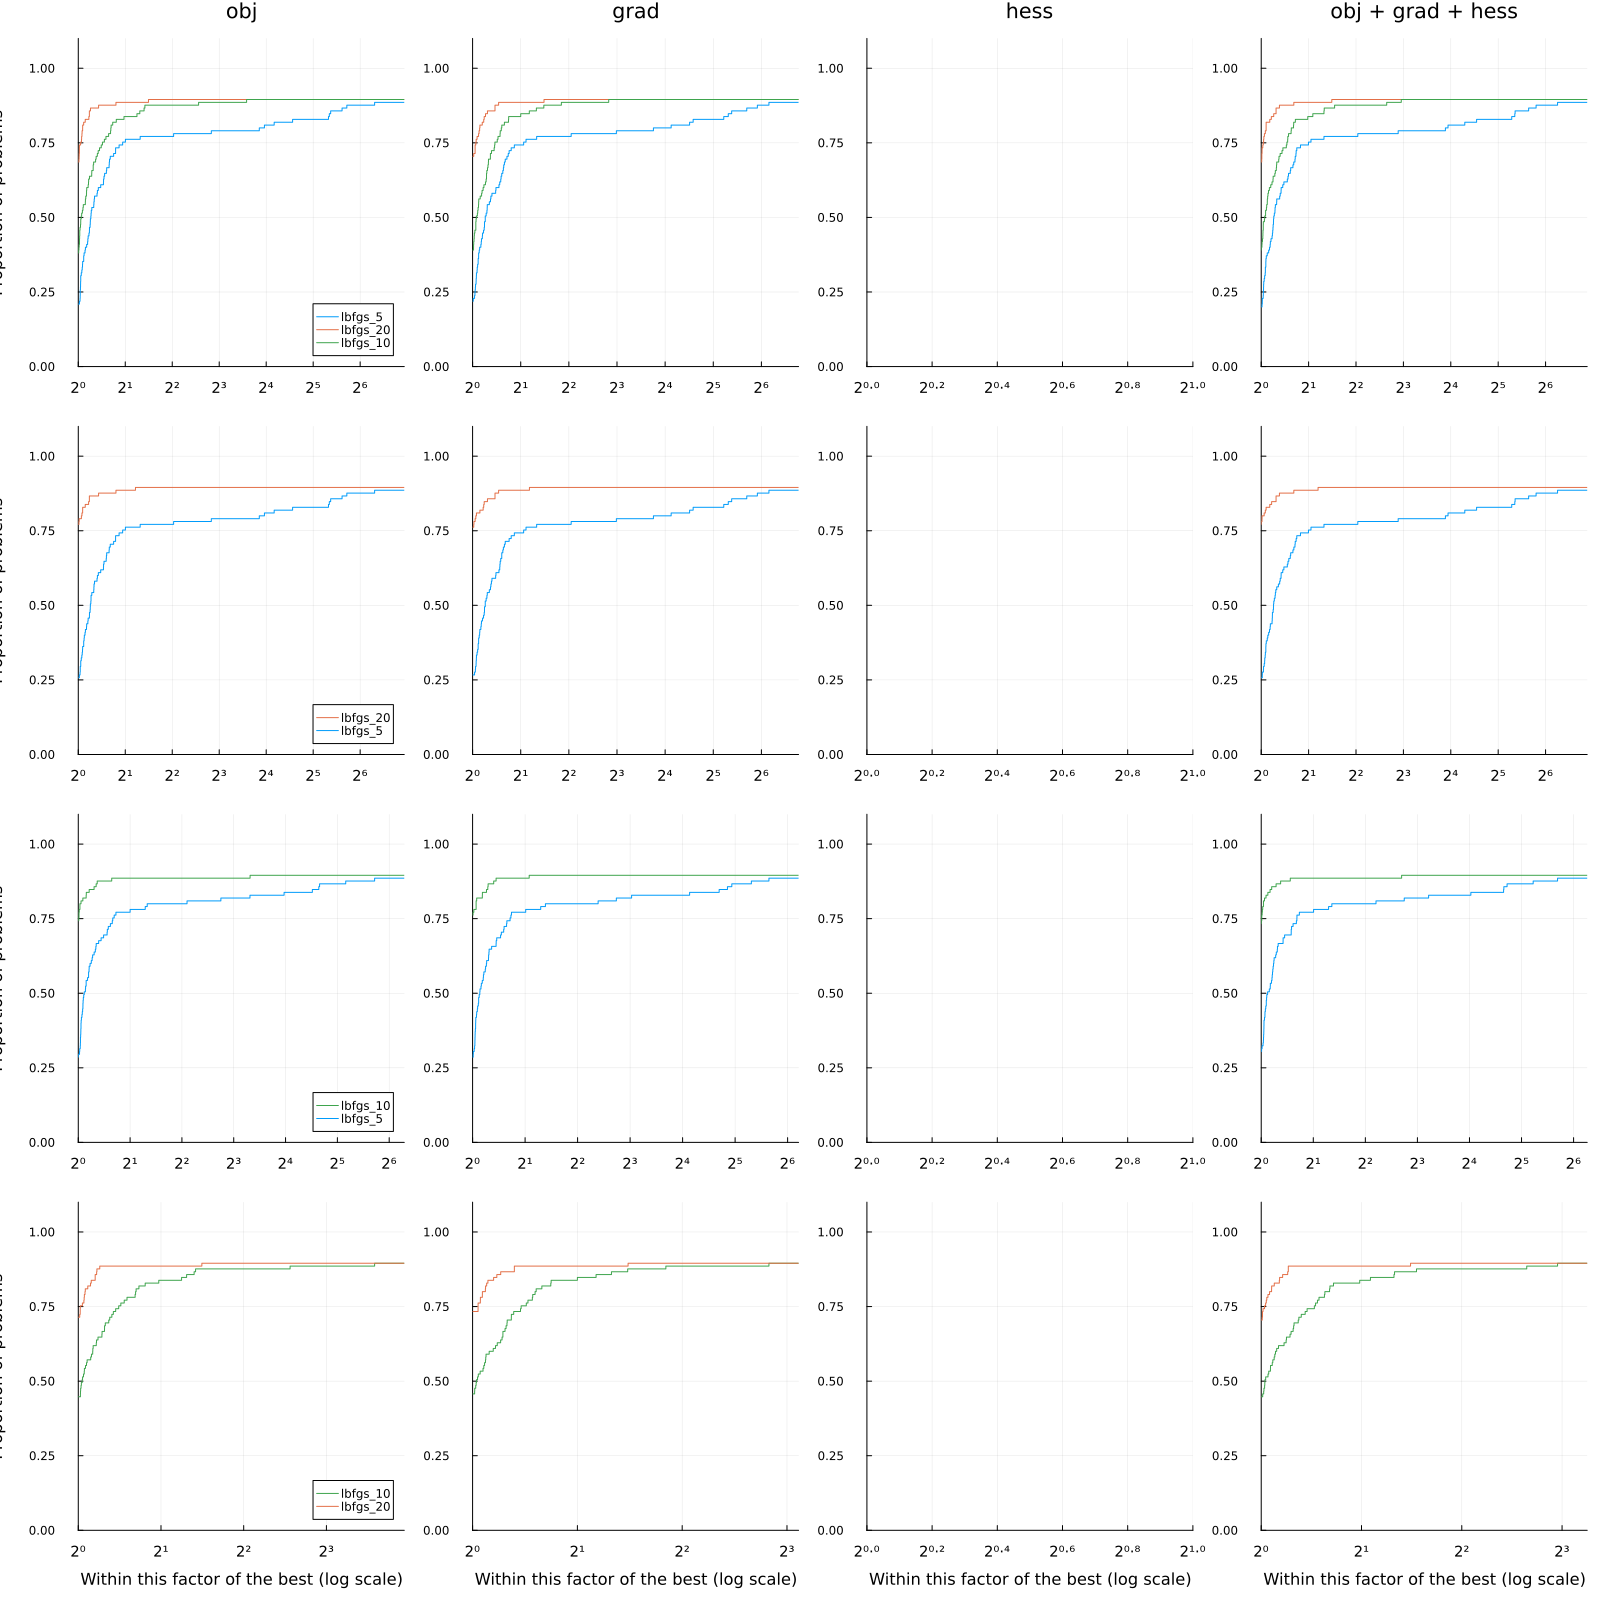

In [32]:
# this code was found partially @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["obj","grad","hess", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_obj,
  df -> .!solved(df) .* Inf .+ df.neval_grad,
  df -> .!solved(df) .* Inf .+ df.neval_hess,
  df -> .!solved(df) .* Inf .+ df.neval_obj .+ df.neval_grad .+ df.neval_hess,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)

**Analyse des résultats:**

On utilise ici 105 problèmes, les profils de performance sont présentés ci-haut. À noter que je n'impose pas la dimension des problèmes, car cela fait crash les solveurs pour une raison mystérieuse. Ces 105 problèmes prennent environ 20 min à rouler. Je ne vais donc pas augmenter davantage la taille.


On remarque sans surprise que la méthode lbfgs 20 qui a une plus grande mémoire résouds un peu plus de problèmes que les deux autres méthodes, mais plus on accepte un facteur loin du meilleur plus les deux autres méthodes deviennent compétitives. En effet, pour 2^3 et plus, les trois solveurs se confondent. 


En se référant au tableau généré plus haut, on remarque que le problème osborne1 n'est pas résolu par les trois solveurs testés. On peut obtenir cette information avec la colonne status qui indique qu'on a atteint le temps maximal de calcul pour ce problème.

###  <font color="lightgreen"> Exercice 4: Benchmark LBFGS vs Newton-CG </font>

Comparer la meilleure variante obtenue (justifier) à l’Exercice 3 et comparer cette méthode à Newton-CG sur la même collection de problèmes sans contraintes de OptimizationProblems.jl. Préciser combien de problèmes sont utilisés, inclure des profils de performance, et mentionner un/des problèmes qui ne sont pas résolus par l’algorithme.

---
---

SOLUTION:

Étant donné que la méthode lbfgs_20 résoud davantage de problèmes que les deux autres méthodes, nous allons utiliser cet algorithme.

In [33]:

ad_problems = (eval(Meta.parse(problem))()  for problem ∈ OptimizationProblems.meta[!, :name])


solvers = Dict(
  :newton_cg => model -> armijo_Newton_cg(model),
  :lbfgs_20 => model -> limited_bfgs(model; mem=20),
)

stats = bmark_solvers(
  solvers, ad_problems,
  skipif=prob -> (!unconstrained(prob) || get_nvar(prob) > 150 || get_nvar(prob) < 5),
)

┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:            NZF1      91       0      first_order   5.0e-01   2.1e+04   3.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         arglina     100       0      first_order   3.3e-01   5.0e+01   7.8e-15   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinb     100       0      first_order   3.4e-01   2.5e+01   2.1e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         arglinc     100       0      first_order   2.9e-01   5.1e+01   1.8e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         argtrig     100       0         not_desc   0.0e+00   7.5e-01   5.8e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         arwhead     100       0      first_order   3.2e-01   0.0e+00   3.6e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         bdqrtic     100       0      first_order   3.4e-01   1.9e+02   7.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          biggs6       6       0      first_order   3.5e-04  -1.0e+01   8.0e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         brownal     100       0      first_order   3.6e-01   1.9e-09   6.2e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:       broyden3d     100       0      first_order   3.4e-01   5.1e-15   4.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        broydn7d     100       0         not_desc   4.4e-01   9.8e+01   3.7e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          brybnd     100       0      first_order   3.6e-01   2.1e-16   1.4e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: catenary: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:4
┌ Warning: catenary: number of variables adjusted to be greater or equal to 6
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/catenary.jl:6
┌ Info:        chainwoo     100       0         not_desc   3.8e-01   1.7e+03   3.5e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        chnrosnb     100       0         not_desc   3.3e-01   9.1e+01   1.5e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        clplatea     100       0      first_order   5.3e-01  -9.1e-03   2.4e-10   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        clplateb     100       0      first_order   5.1e-01  -6.2e-03   9.0e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        clplatec     100       0      first_order   5.6e-01  -5.1e-03   7.0e-11   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          cosine     100       0         not_desc   0.0e+00   8.7e+01   7.2e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        cragglvy     100       0      first_order   3.9e-01   3.2e+01   5.8e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:       cragglvy2     100       0      first_order   3.5e-01   2.5e+01   1.9e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           curly     100       0         not_desc   0.0e+00  -6.2e-03   1.3e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly10     100       0         not_desc   0.0e+00  -6.2e-03   1.3e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         curly20     100       0         not_desc   0.0e+00  -1.3e-02   2.8e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly30     100       0         not_desc   0.0e+00  -2.0e-02   4.6e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12


┌ Info:        dixmaane      99       0      first_order   4.0e-01   1.0e+00   1.2e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12


┌ Info:        dixmaanf      99       0      first_order   4.0e-01   1.0e+00   1.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaang      99       0      first_order   1.9e-02   1.0e+00   7.8e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaanh      99       0      first_order   1.7e-02   1.0e+00   7.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaani      99       0      first_order   5.4e-01   1.0e+00   8.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_ijkl.jl:12


┌ Info:        dixmaanj      99       0      first_order   5.0e-01   1.0e+00   1.0e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_ijkl.jl:12


┌ Info:        dixmaank      99       0      first_order   1.1e-01   1.0e+00   6.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_ijkl.jl:12


┌ Info:        dixmaanl      99       0      first_order   1.0e-01   1.0e+00   5.9e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12


┌ Info:        dixmaanm      99       0      first_order   5.5e-01   1.0e+00   9.5e-10   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12


┌ Info:        dixmaann      99       0      first_order   6.4e-01   1.0e+00   2.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12


┌ Info:        dixmaano      99       0      first_order   1.9e-01   1.0e+00   2.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12


┌ Info:        dixmaanp      99       0      first_order   1.6e-01   1.0e+00   2.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        dixon3dq     100       0      first_order   3.0e-01   0.0e+00   0.0e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         dqdrtic     100       0      first_order   2.9e-01   1.8e-11   8.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          dqrtic     100       0      first_order   3.1e-01   1.9e-02   6.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         edensch     100       0      first_order   3.1e-01   6.0e+02   4.0e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:             eg2     100       0      first_order   3.3e-01  -9.9e+01   1.4e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         engval1     100       0      first_order   2.9e-01   1.1e+02   3.3e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:            enso       9       0         not_desc   8.4e-04   5.0e+02   3.0e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        errinros     100       0      first_order   4.3e-01   3.9e+01   1.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        extrosnb     100       0      first_order   5.0e-01   3.6e-06   8.2e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        fletcbv2     100       0      first_order   4.1e-01  -5.1e-01   1.2e-10   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        fletcbv3     100       0         not_desc   3.5e-01  -4.1e-02   1.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        fletchcr     100       0         max_time   3.0e+01       NaN       NaN   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        fminsrf2     100       0      first_order   6.3e-01   1.0e+02   1.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        freuroth     100       0         not_desc   0.0e+00   5.0e+04   3.9e+03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss1       8       0      first_order   4.6e-03   6.6e+02   5.9e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss2       8       0      first_order   5.6e-03   6.2e+02   4.5e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          gauss3       8       0      first_order   8.8e-03   6.2e+02   5.8e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        genhumps     100       0         not_desc   0.0e+00   2.5e+06   8.5e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         genrose     100       0         not_desc   3.5e-01   3.9e+02   5.4e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:    genrose_nash     100       0         not_desc   3.1e-01   3.9e+02   5.2e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           hahn1       7       0         not_desc   5.7e-03   5.4e+03   2.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           indef     100       0         not_desc   0.0e+00   9.2e+01   1.1e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        integreq     100       0      first_order   5.6e-01   3.4e-20   2.6e-10   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          kirby2       5       0      first_order   1.5e-03   1.5e+01   5.6e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0         not_desc   3.0e-04   1.5e-03   1.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0         not_desc   3.0e-04   1.5e-03   1.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0         not_desc   2.9e-04   1.5e-03   1.1e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         liarwhd     100       0      first_order   2.9e-01   6.7e-15   2.9e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           mgh17       5       0         not_desc   7.3e-05   5.9e-02   4.7e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          morebv     100       0      first_order   6.1e-01   1.0e-12   2.2e-09   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           ncb20     100       0         not_desc   4.7e-01   1.8e+02   4.7e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          ncb20b     100       0         not_desc   1.1e+00   2.0e+02   1.6e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxu2     100       0         not_desc   0.0e+00   2.6e+06   9.5e+03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        noncvxun     100       0         not_desc   0.0e+00   2.7e+06   1.0e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          nondia     100       0      first_order   2.8e-01   1.4e-08   4.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        nondquar     100       0      first_order   5.2e-01   5.8e-09   2.5e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne1       5       0      first_order   2.2e-03   2.4e-02   4.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne2      11       0         not_desc   5.6e-04   1.7e-01   6.9e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   4.1e-03   8.4e+01   1.3e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   3.5e-03   1.4e+01   1.7e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first

┌ Info:        penalty1     100       0      first_order   3.2e-01   1.4e+00   4.6e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        penalty2     100       0      first_order   4.0e-01   9.7e+04   7.6e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        penalty3     100       0         not_desc   4.8e-01   1.0e+08   5.8e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        powellsg     100       0      first_order   3.3e-01   7.0e-08   1.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           power     100       0      first_order   2.8e-01   1.8e-03   4.7e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          quartc     100       0      first_order   3.1e-01   1.9e-02   6.4e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         sbrybnd     100       0         not_desc   0.0e+00   7.8e+02   2.7e+04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        schmvett     100       0         not_desc   0.0e+00  -1.9e+02   2.0e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         scosine     100       0         not_desc   0.0e+00   8.7e+01   8.1e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         sinquad     100       0         not_desc   3.3e-01   1.1e-01   2.8e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        sparsine     100       0      first_order   5.1e-01   2.1e+03   2.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsqur     100       0      first_order   3.2e-01   1.7e-08   6.2e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        spmsrtls     100       0         not_desc   0.0e+00   3.6e+01   4.8e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        srosenbr     100       0         not_desc   2.8e-01   2.1e+02   1.4e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         thurber       7       0         not_desc   2.3e-03   1.5e+04   1.4e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        tointgss     100       0      first_order   3.2e-01   9.7e+00   3.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:        tquartic     100       0         not_desc   2.9e-01   3.6e-01   4.7e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          tridia     100       0      first_order   2.2e-02   3.4e-13   1.1e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          vardim     100       0      first_order   3.2e-01   3.6e+03   1.1e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        vibrbeam       8       0      first_order   1.0e-03   1.6e-01   2.2e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          watson      31       0         not_desc   1.3e-01   1.6e+00   2.9e+01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           woods     100       0         not_desc   3.4e-01   8.1e+02   1.2e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:            Name    nvar    ncon           status      Time      f(x)      Dual    Primal  
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:127
┌ Info:            NZF1      91       0      first_order   1.1e-03   2.1e+04   2.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglina     100       0      first_order   1.4e-04   5.0e+01   7.8e-15   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinb     100       0      first_order   1.4e-04   2.5e+01   3.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         arglinc     100       0      first_order   9.9e-05   5.1e+01   4.4e-03   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         argtrig     100       0      fir

┌ Info:         arwhead     100       0      first_order   1.7e-04   0.0e+00   2.9e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         bdqrtic     100       0      first_order   6.5e-04   1.9e+02   1.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          biggs6       6       0        unbounded   2.4e-05  -3.2e+22   4.1e+22   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         brownal     100       0      first_order   9.8e-05   1.9e-09   6.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:       broyden3d     100       0      first_order   1.3e-03   3.6e-01   3.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        broydn7d     100       0      first

┌ Info:          cosine     100       0      first_order   4.2e-04  -9.9e+01   2.8e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        cragglvy     100       0      first_order   1.8e-03   3.2e+01   3.8e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:       cragglvy2     100       0      first_order   1.8e-03   2.5e+01   5.6e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           curly     100       0         max_time   3.0e+01  -1.0e+04   3.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly10     100       0         max_time   3.0e+01  -1.0e+04   3.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         curly20     100       0         max_time   3.0e+01  -1.0e+04   5.0e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         curly30     100       0         max_time   3.0e+01  -1.0e+04   3.7e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaane      99       0      first_order   4.0e-03   1.0e+00   1.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_efgh.jl:12
┌ Info:        dixmaanf      99       0      first_order   4.3e-03   1.0e+00   3.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaanl      99       0      first_order   1.4e-02   1.0e+00   1.5e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanm      99       0      first_order   5.0e-02   1.0e+00   1.1e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaann      99       0      first_order   3.2e-02   1.0e+00   2.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: numb

┌ Info:        dixmaano      99       0      first_order   3.2e-02   1.0e+00   4.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Warning: dixmaan: number of variables adjusted to be a multiple of 3
└ @ OptimizationProblems.ADNLPProblems /home/julien/.julia/packages/OptimizationProblems/fiJkh/src/ADNLPProblems/dixmaan_mnop.jl:12
┌ Info:        dixmaanp      99       0      first_order   3.4e-02   1.0e+00   8.0e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        dixon3dq     100       0      first_order   4.0e-03   3.4e-14   4.8e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         dqdrtic     100       0      first_order   1.9e-04   4.0e-12   4.3e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          dqrtic     100      

┌ Info:        genhumps     100       0      first_order   6.6e-02   3.5e-11   3.7e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         genrose     100       0      first_order   4.0e-03   1.0e+00   1.8e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:    genrose_nash     100       0      first_order   4.5e-03   1.0e+00   1.2e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           hahn1       7       0         max_time   3.0e+01   2.7e+04   5.2e+06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:           indef     100       0         max_time   3.0e+01  -9.8e+03   6.6e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        integreq     100       0      first_order   2.0e-02   5.8e-17   1.1e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          kirby2       5       0      first_order   2.5e-03   1.5e+01   5.5e+02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos1       6       0      first_order   2.0e-04   2.1e-06   5.8e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos2       6       0      first_order   2.1e-04   2.1e-06   3.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        lanczos3       6       0      first

┌ Info:          morebv     100       0      first_order   4.5e-01   2.7e-11   3.7e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:           ncb20     100       0         max_time   3.0e+01   1.7e+02   6.6e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:          ncb20b     100       0         max_time   3.0e+01   2.0e+02   2.4e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxu2     100       0      first_order   1.2e-02   2.3e+02   1.3e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        noncvxun     100       0      first_order   4.3e-03   2.3e+02   1.5e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:          nondia     100       0      first_order   2.9e-04   3.4e-15   7.8e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        nondquar     100       0      first_order   2.3e-02   7.4e-07   5.6e-06   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        osborne1       5       0         ma

┌ Info:        osborne2      11       0      first_order   7.5e-04   2.0e-02   2.6e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1c       8       0      first_order   6.9e-03   8.4e+01   1.8e+00   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer1d       7       0      first_order   6.2e-03   1.4e+01   2.5e-01   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer2c       8       0      first_order   3.3e-03   2.2e+00   9.1e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer3c       8       0      first_order   2.3e-03   1.7e+00   7.8e-02   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        palmer4c       8       0      first

┌ Info:         sbrybnd     100       0      first_order   3.2e+00   7.6e+00   3.7e-04   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        schmvett     100       0      first_order   6.0e-04  -2.9e+02   1.1e-07   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175


┌ Info:         scosine     100       0         max_time   3.0e+01  -7.8e+01   4.6e+05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:         sinquad     100       0      first_order   2.9e-03   9.8e-16   3.9e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsine     100       0      first_order   2.0e-02   4.3e-10   9.1e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        sparsqur     100       0      first_order   6.0e-04   4.7e-08   1.6e-05   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        spmsrtls     100       0      first_order   8.1e-03   7.7e-15   7.3e-08   0.0e+00
└ @ SolverBenchmark /home/julien/.julia/packages/SolverBenchmark/YM13z/src/run_solver.jl:175
┌ Info:        srosenbr     100       0      first

Dict{Symbol, DataFrames.DataFrame} with 2 entries:
  :newton_cg => 105×39 DataFrame…
  :lbfgs_20  => 105×39 DataFrame…

In [34]:
# this code was found as is @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

cols = [:id, :name, :nvar, :objective, :dual_feas, :neval_obj, :neval_grad, :neval_hess, :iter, :elapsed_time, :status]
header = Dict(
  :nvar => "n",
  :objective => "f(x)",
  :dual_feas => "‖∇f(x)‖",
  :neval_obj => "# f",
  :neval_grad => "# ∇f",
  :neval_hess => "# ∇²f",
  :elapsed_time => "t",
)
for solver ∈ keys(solvers)
    pretty_stats(stats[solver][!, cols], hdr_override=header)
  end

┌────────┬──────────────┬────────┬───────────┬───────────┬─────────┬─────────┬────────┬─────────┬───────────┬─────────────┐
│     id │         name │      n │      f(x) │   ‖∇f(x)‖ │     # f │    # ∇f │  # ∇²f │    iter │         t │      status │
├────────┼──────────────┼────────┼───────────┼───────────┼─────────┼─────────┼────────┼─────────┼───────────┼─────────────┤
│     25 │         NZF1 │     91 │  2.09e+04 │  3.56e-05 │      18 │      18 │      0 │      17 │  5.03e-01 │ first_order │
│     38 │      arglina │    100 │  5.00e+01 │  7.84e-15 │       2 │       2 │      0 │       1 │  3.31e-01 │ first_order │
│     39 │      arglinb │    100 │  2.48e+01 │  2.05e-04 │       2 │       2 │      0 │       1 │  3.38e-01 │ first_order │
│     40 │      arglinc │    100 │  5.11e+01 │  1.81e-03 │       2 │       2 │      0 │       1 │  2.92e-01 │ first_order │
│     41 │      argtrig │    100 │  7.52e-01 │  5.82e+00 │       1 │       1 │      0 │       0 │  0.00e+00 │    not_desc │
│     42

┌ Warning: some measures are zero; shifting all by one
└ @ BenchmarkProfiles /home/julien/.julia/packages/BenchmarkProfiles/KnjdY/src/performance_profiles.jl:16


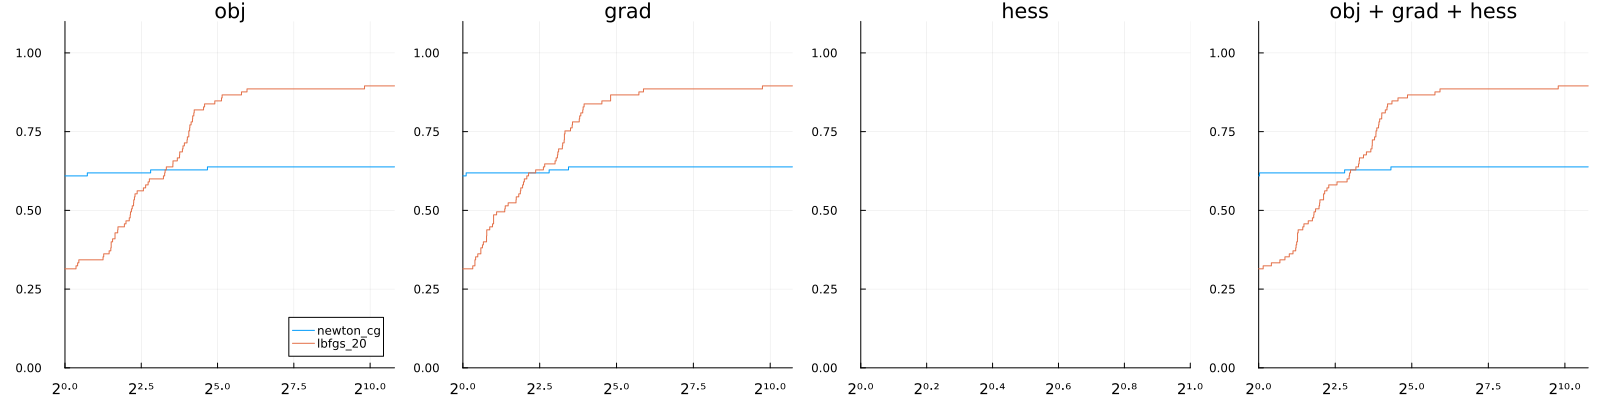

In [35]:
# this code was found partially @ https://jso.dev/OptimizationProblems.jl/dev/benchmark/

first_order(df) = df.status .== :first_order
unbounded(df) = df.status .== :unbounded
solved(df) = first_order(df) .| unbounded(df)
costnames = ["obj","grad","hess", "obj + grad + hess"]
costs = [
  df -> .!solved(df) .* Inf .+ df.neval_obj,
  df -> .!solved(df) .* Inf .+ df.neval_grad,
  df -> .!solved(df) .* Inf .+ df.neval_hess,
  df -> .!solved(df) .* Inf .+ df.neval_obj .+ df.neval_grad .+ df.neval_hess,
]

using Plots
gr()

profile_solvers(stats, costs, costnames)

J'ai un peu de la misère à comprendre les graphiques et j'utilise cet article comme référence: https://link.springer.com/article/10.1007/s101070100263.

De ce que je comprends, Newton-CG a environ 60\% de probabilité d'être le meilleur initialement, mais plus on est tolérant plus lbfgs20 devient compétitif.

On a produit les profils de performance à partir des 105 problèmes utilisés à l'exercice 3. 

On remarque cette fois-ci que osborne1 est résolu par newton-cg, mais que fletchcr n'est pas résolu (status = max_time). On retrouve aussi plusieurs problèmes avec le status not_desc, mais je n'ai pas réussi à trouver de la documentation qui explique ce que ça signifie quant à la résolution des problèmes.

